In [11]:
# IMPORTS
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Load the dataset
train_path = '/content/twitter_training.csv'
valid_path = '/content/twitter_validation.csv'
try:
    df_train = pd.read_csv(train_path)
    df_valid = pd.read_csv(valid_path)
except Exception:
    df_train = pd.read_csv(train_path, encoding='latin1')
    df_valid = pd.read_csv(valid_path, encoding='latin1')

# Quick check
print("TRAIN shape:", df_train.shape)
print("VALID shape:", df_valid.shape)

print("\nTRAIN columns:", df_train.columns.tolist())
print("\nVALID columns:", df_valid.columns.tolist())

display(df_train.head(10))
display(df_valid.head(10))

TRAIN shape: (74681, 4)
VALID shape: (999, 4)

TRAIN columns: ['2401', 'Borderlands', 'Positive', 'im getting on borderlands and i will murder you all ,']

VALID columns: ['3364', 'Facebook', 'Irrelevant', 'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣']


,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
5,2402,Borderlands,Positive,So I spent a few hours making something for fu...
6,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
7,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
8,2402,Borderlands,Positive,So I spent a few hours making something for fu...
9,2402,Borderlands,Positive,2010 So I spent a few hours making something f...


,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
5,7925,MaddenNFL,Positive,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...
6,11332,TomClancysRainbowSix,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ..."
7,1107,AssassinsCreed,Positive,my ass still knee-deep in Assassins Creed Odys...
8,2069,CallOfDuty,Negative,FIX IT JESUS ! Please FIX IT ! What In the wor...
9,3185,Dota2,Positive,The professional dota 2 scene is fucking explo...


In [13]:
# Load both files (header=None)
df_train = pd.read_csv(train_path, header=None, encoding='utf-8', engine='python')
df_valid = pd.read_csv(valid_path, header=None, encoding='utf-8', engine='python')

print("Raw shapes:", df_train.shape, df_valid.shape)
print("First row of train as header (shows what was misread):")
display(df_train.head(2))
display(df_valid.head(2))

# Assign clear column names
cols = ['entity_id', 'platform', 'sentiment', 'text']
df_train.columns = cols
df_valid.columns = cols

# Add a split column so we know origin
df_train['split'] = 'train'
df_valid['split'] = 'valid'

# Combine
df = pd.concat([df_train, df_valid], ignore_index=True)
print("Combined shape:", df.shape)
df.head(5)

Raw shapes: (74682, 4) (1000, 4)
First row of train as header (shows what was misread):


,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...


,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...


Combined shape: (75682, 5)


,entity_id,platform,sentiment,text,split
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,train
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,train
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,train
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,train
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,train


In [14]:
# Basic cleaning
df['text'] = df['text'].astype(str).str.strip()
df['platform'] = df['platform'].astype(str).str.strip()
df['sentiment'] = df['sentiment'].astype(str).str.strip().str.title()  # e.g. Positive/Negative/Irrelevant/Neutral

# If there are 'Irrelevant' labels
print("Sentiment value counts:")
display(df['sentiment'].value_counts())

# drop rows with missing text
df = df[df['text'].str.len() > 0].reset_index(drop=True)

Sentiment value counts:


,count
sentiment,
Negative,22808
Positive,21109
Neutral,18603
Irrelevant,13162


In [15]:
# helper functions
url_re = re.compile(r'http\S+|www\.\S+')
mention_re = re.compile(r'@\w+')
hashtag_re = re.compile(r'#\w+')
emoji_re = re.compile("[\U00010000-\U0010ffff]", flags=re.UNICODE)

def count_regex(pattern, s):
    return len(pattern.findall(s))

def uppercase_ratio(s):
    letters = [c for c in s if c.isalpha()]
    if not letters: return 0.0
    upp = sum(1 for c in letters if c.isupper())
    return upp / len(letters)

# create features
df['text_len'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().apply(len)
df['num_urls'] = df['text'].apply(lambda x: len(url_re.findall(x)))
df['num_mentions'] = df['text'].apply(lambda x: len(mention_re.findall(x)))
df['num_hashtags'] = df['text'].apply(lambda x: len(hashtag_re.findall(x)))
df['num_exclaims'] = df['text'].str.count('!')
df['num_questions'] = df['text'].str.count(r'\?')
df['num_emojis'] = df['text'].apply(lambda x: len(emoji_re.findall(x)))
df['uppercase_ratio'] = df['text'].apply(uppercase_ratio)

# quick sanity check
df[['text','text_len','word_count','num_urls','num_mentions','num_hashtags','num_emojis','uppercase_ratio']].head()

,text,text_len,word_count,num_urls,num_mentions,num_hashtags,num_emojis,uppercase_ratio
0,im getting on borderlands and i will murder yo...,53,11,0,0,0,0,0.000000
1,I am coming to the borders and I will kill you...,51,12,0,0,0,0,0.051282
2,im getting on borderlands and i will kill you ...,50,10,0,0,0,0,0.000000
3,im coming on borderlands and i will murder you...,51,10,0,0,0,0,0.000000
4,im getting on borderlands 2 and i will murder ...,57,12,0,0,0,0,0.000000


/tmp/ipython-input-1504254777.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', order=df['sentiment'].value_counts().index, palette='pastel')


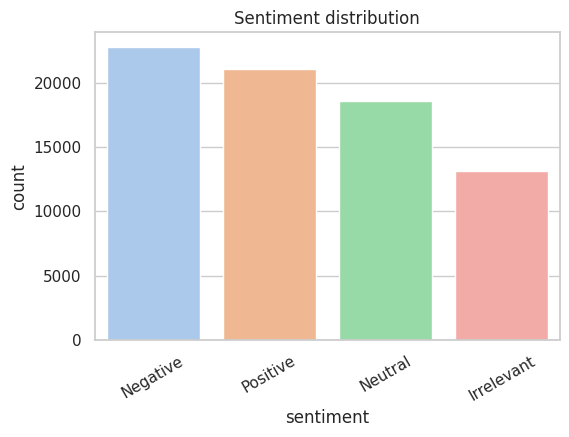

In [16]:
sns.set(style='whitegrid')

# 1) Sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', order=df['sentiment'].value_counts().index, palette='pastel')
plt.title('Sentiment distribution')
plt.xticks(rotation=30)
plt.show()

/tmp/ipython-input-657184963.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_platforms.values, y=top_platforms.index, palette='magma')


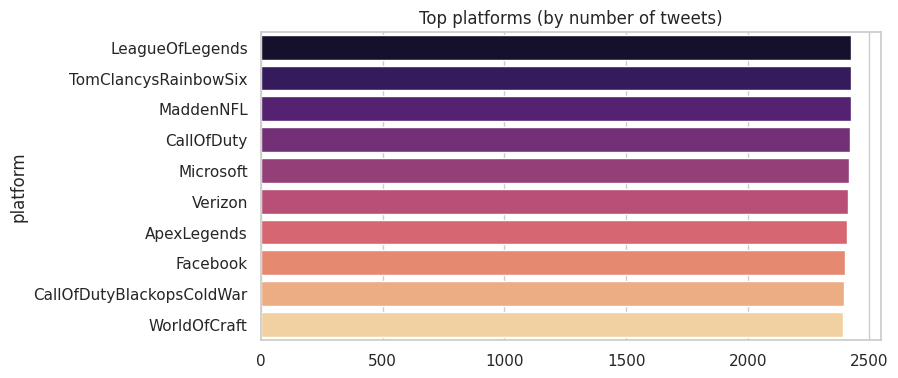

In [17]:
# 2) Top platforms
plt.figure(figsize=(8,4))
top_platforms = df['platform'].value_counts().nlargest(10)
sns.barplot(x=top_platforms.values, y=top_platforms.index, palette='magma')
plt.title('Top platforms (by number of tweets)')
plt.show()

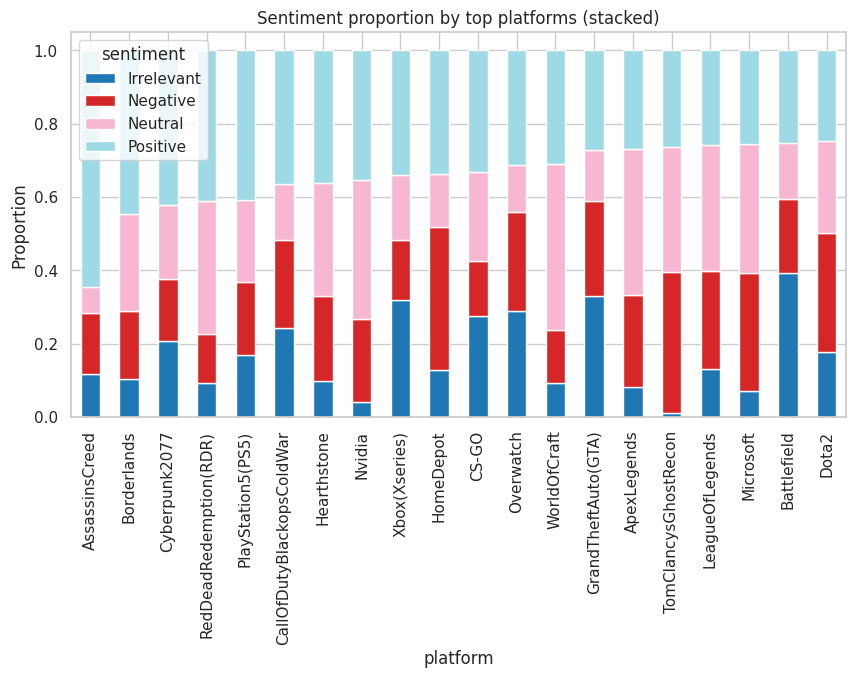

In [18]:
# 3) Sentiment by platform (proportion)
platform_sent = df.groupby(['platform','sentiment']).size().unstack(fill_value=0)
platform_prop = platform_sent.div(platform_sent.sum(axis=1), axis=0).sort_values(by='Positive', ascending=False).head(20)
platform_prop.plot(kind='bar', stacked=True, figsize=(10,5), colormap='tab20')
plt.title('Sentiment proportion by top platforms (stacked)')
plt.ylabel('Proportion')
plt.show()

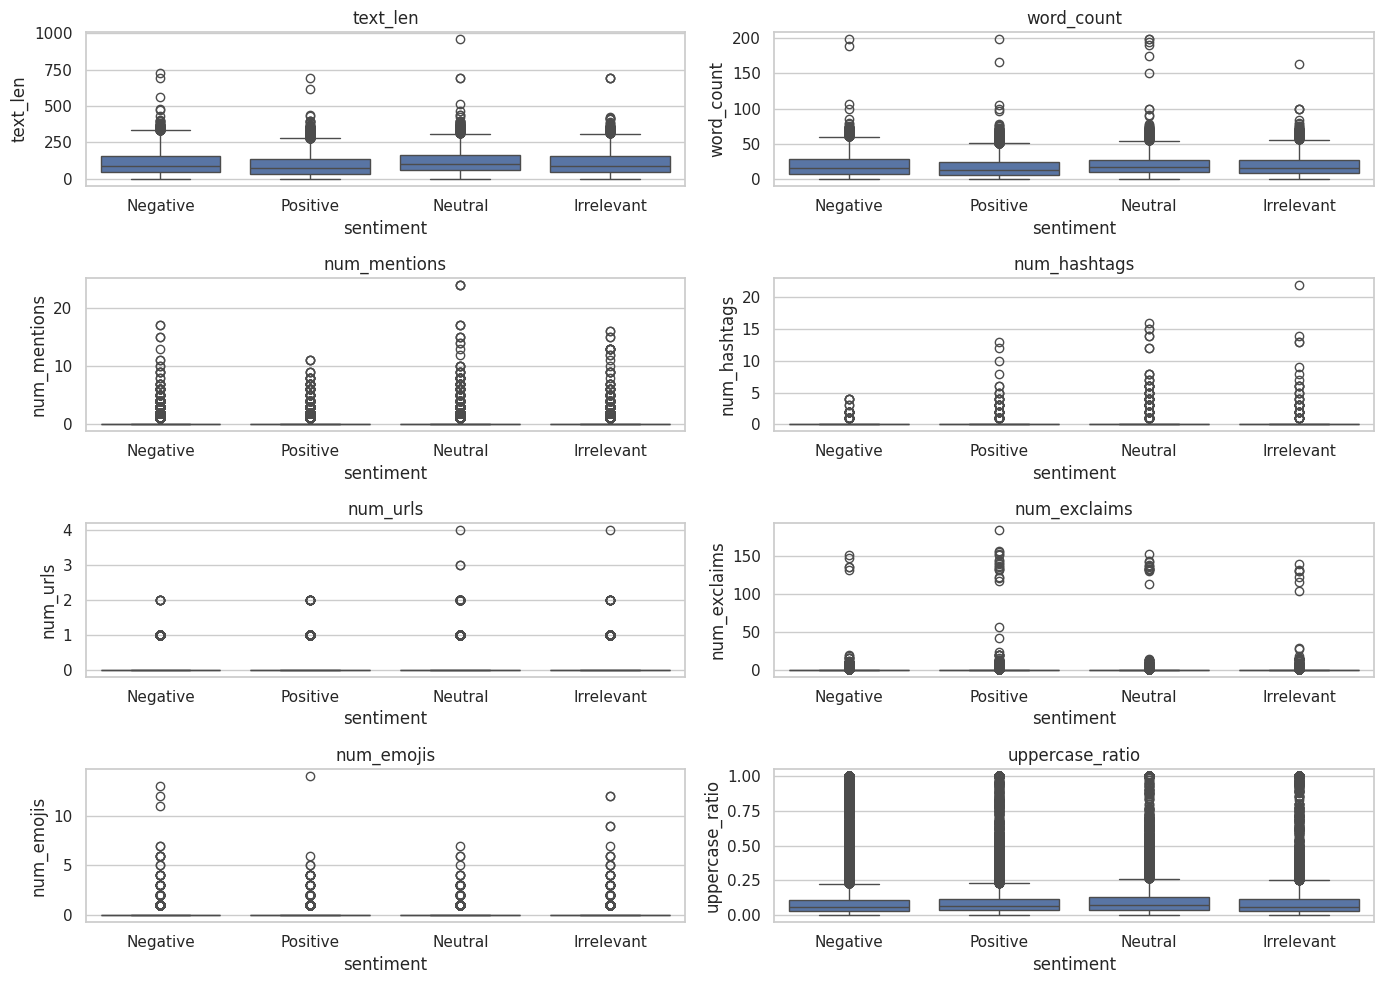

In [19]:
# 4) Feature distributions by sentiment (boxplots)
num_feats = ['text_len','word_count','num_mentions','num_hashtags','num_urls','num_exclaims','num_emojis','uppercase_ratio']
plt.figure(figsize=(14,10))
for i, feat in enumerate(num_feats,1):
    plt.subplot(4,2,i)
    sns.boxplot(data=df, x='sentiment', y=feat, order=df['sentiment'].value_counts().index)
    plt.title(feat)
plt.tight_layout()
plt.show()

In [20]:
# Average feature values per sentiment
avg_feats = df.groupby('sentiment')[['text_len','word_count','num_mentions','num_hashtags','num_urls','num_exclaims','num_emojis','uppercase_ratio']].mean().round(3)
display(avg_feats)

# Top entities by count and their positive rate
ent = df.groupby('entity_id').agg(total=('text','size'), positive_rate=('sentiment', lambda s: (s=='Positive').mean()))
top_entities = ent[ent['total']>50].sort_values('total', ascending=False).head(30)
display(top_entities.head(10))

,text_len,word_count,num_mentions,num_hashtags,num_urls,num_exclaims,num_emojis,uppercase_ratio
sentiment,,,,,,,,
Irrelevant,110.509,19.551,0.217,0.015,0.029,0.411,0.031,0.101
Negative,110.706,19.946,0.345,0.004,0.013,0.245,0.018,0.109
Neutral,118.233,20.121,0.207,0.022,0.082,0.414,0.019,0.108
Positive,95.501,17.106,0.177,0.009,0.021,0.529,0.019,0.107


,total,positive_rate
entity_id,,


In [21]:
# Create a binary target for "positive" tweets
df['is_positive'] = (df['sentiment'] == 'Positive').astype(int)

# Correlation of numeric features with positivity
corr = df[['is_positive','text_len','word_count','num_mentions','num_hashtags','num_urls','num_exclaims','num_emojis','uppercase_ratio']].corr()

corr['is_positive'].sort_values(ascending=False)

,is_positive
is_positive,1.000000
num_exclaims,0.024698
uppercase_ratio,0.001728
num_emojis,-0.004255
num_hashtags,-0.006371
num_urls,-0.044277
num_mentions,-0.052760
word_count,-0.087008
text_len,-0.099579
